<div class='heading'>
    <div style='float:left;'><h1>CPSC 4300/6300: Applied Data Science</h1></div>
    <img style="float: right; padding-right: 10px; width: 65px" src="https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/images/clemson_paw.png"> </div>


## Homework 6: Logistic Regression

**Clemson University**<br>
**Fall 2021**<br>
**Instructor(s):** Nina Hubig <br>


---



In [1]:
""" RUN THIS CELL TO GET THE RIGHT FORMATTING """
import requests
from IPython.core.display import HTML
css_file = 'https://raw.githubusercontent.com/bsethwalker/clemson-cs4300/main/css/cpsc6300.css'
styles = requests.get(css_file).text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and are aiming to teach. And if a problem specifies a particular library, you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from scipy.stats import ttest_ind

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The dataset is provided in the file `hw6_enhance.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.

In [56]:
""" 
Use this code to load and split your data set in order to ensure that everyone
has the same splits. 
"""

# Load data
df = pd.read_csv('hw6_enhance.csv', index_col=0)
print(df.shape)




(752, 7130)


In [55]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                    df.Cancer_type, 
                                                    test_size=0.2, 
                                                    random_state=4300, 
                                                    stratify=df.Cancer_type)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(601, 7129) (151, 7129) (601,) (151,)


In [53]:
print(df.Cancer_type.value_counts(normalize=True))

0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


In [57]:
df.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.0,-214.0,-153.0,-58.0,88.0,-295.0,-558.0,199.0,-176.0,252.0,...,185.0,511.0,-125.0,389.0,-37.0,793.0,329.0,36.0,191.0,-37.0
1,0.0,-135.0,-114.0,265.0,12.0,-419.0,-585.0,158.0,-253.0,49.0,...,240.0,835.0,218.0,174.0,-110.0,627.0,170.0,-50.0,126.0,-91.0
2,0.0,-106.0,-125.0,-76.0,168.0,-230.0,-284.0,4.0,-122.0,70.0,...,156.0,649.0,57.0,504.0,-26.0,250.0,314.0,14.0,56.0,-25.0
3,0.0,-72.0,-144.0,238.0,55.0,-399.0,-551.0,131.0,-179.0,126.0,...,30.0,819.0,-178.0,151.0,-18.0,1140.0,482.0,10.0,369.0,-42.0
4,0.0,-413.0,-260.0,7.0,-2.0,-541.0,-790.0,-275.0,-463.0,70.0,...,289.0,629.0,-86.0,302.0,23.0,1798.0,446.0,59.0,781.0,20.0


**1.1** Take a peek at your training set (Using the `describe()` method): you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values**. To make the provided code in the remainder of the notebook work without modification, name the scaled train and test sets `X_train` and `X_test`. 

In [58]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,-120.795656,-160.407102,26.997976,211.942012,-252.426995,-416.781901,-42.076568,-191.435182,77.387337,104.534865,...,161.399263,710.636033,0.248612,436.104496,-48.880010,841.730473,348.145381,14.814450,461.693197,-25.014174
std,171.676753,192.806471,206.166533,194.234845,203.449246,252.096031,530.218262,160.653938,172.788351,363.150587,...,159.921877,508.276336,148.408642,622.735097,105.639544,818.773446,371.588448,84.123605,911.427781,69.563460
min,-894.789505,-1095.737090,-645.439001,-325.878508,-1154.285694,-1071.504144,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-501.285884,-701.425412,-418.992454,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-218.537298,-264.786533,-98.813712,86.595873,-379.248241,-578.526260,-344.026057,-296.864667,-18.896068,-112.563649,...,74.052467,384.503146,-94.034240,81.000000,-104.000000,285.019079,111.731904,-39.338442,-93.138040,-71.712907
50%,-108.800744,-145.610522,21.183690,203.241689,-233.976385,-437.530934,-61.884619,-179.262096,89.812774,102.200750,...,156.427803,679.703227,0.462306,385.056635,-38.244427,771.309173,306.306932,14.000000,370.362678,-26.247974
75%,-11.352664,-43.129985,136.069868,335.853991,-123.674384,-266.828809,288.134251,-82.188046,197.734240,300.334947,...,258.914343,1066.000000,90.728416,735.551039,19.775025,1311.676527,551.841067,71.309713,1007.516778,17.828975
max,516.618491,384.626762,748.233182,1022.560525,431.217287,607.737258,1385.881293,263.634029,589.778466,1698.037385,...,686.321597,2366.855925,471.167579,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3495.139425,198.980948


In [87]:
X_test.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.572655,0.627404,0.482448,0.385302,0.572810,0.391555,0.596504,0.535795,0.624146,0.445602,...,0.557517,0.481023,0.471025,0.382349,0.597958,0.516629,0.366700,0.470332,0.529472,0.487089
std,0.117122,0.127335,0.152112,0.168573,0.139790,0.164374,0.147075,0.163257,0.120832,0.124063,...,0.140227,0.195213,0.178728,0.080376,0.159038,0.128713,0.131855,0.152773,0.164040,0.159099
min,0.222337,0.334273,0.168276,-0.074065,0.065618,-0.011903,0.214945,0.039091,0.291769,0.060883,...,0.201957,-0.100710,-0.031551,0.140710,0.120367,0.061605,0.027648,0.025000,0.022208,0.122784
25%,0.487855,0.536158,0.398338,0.292553,0.489232,0.276662,0.497340,0.413746,0.543458,0.372525,...,0.450498,0.343653,0.366330,0.337388,0.512609,0.423844,0.277686,0.404786,0.432789,0.374874
50%,0.573962,0.643947,0.473959,0.404081,0.590529,0.374493,0.589663,0.549324,0.630248,0.443356,...,0.550306,0.482682,0.482404,0.379106,0.622132,0.514056,0.353210,0.460637,0.503284,0.482698
75%,0.666604,0.715883,0.543945,0.483837,0.664131,0.490525,0.693050,0.653255,0.695716,0.510974,...,0.651364,0.609989,0.572859,0.426066,0.704279,0.601502,0.445534,0.539315,0.644871,0.586259
max,0.855530,0.898234,0.963227,0.834772,0.922838,0.812752,0.936461,0.951292,0.952868,0.814328,...,0.936298,1.050625,1.011967,0.649619,0.931268,0.857796,0.771090,0.905217,1.000864,1.059043


In [59]:
# Your code here
def normalize_columns(X, X_min, X_max):
    return (X-X_min)/(X_max-X_min)

X_min = np.min(X_train,axis=0)
X_max = np.max(X_train,axis=0)

X_train = normalize_columns(X=X_train, X_min=X_min, X_max=X_max)
X_test = normalize_columns(X=X_test, X_min=X_min, X_max=X_max)   

assert np.max(X_train.values)==1 and np.min(X_train.values)==0   

In [60]:
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,0.548384,0.631824,0.482493,0.398847,0.568816,0.389892,0.586387,0.541552,0.623188,0.445681,...,0.558000,0.460213,0.470973,0.394104,0.592714,0.507786,0.377441,0.509880,0.514633,0.487244
std,0.121635,0.130243,0.147930,0.144044,0.128318,0.150125,0.153580,0.161847,0.127069,0.126326,...,0.134659,0.165655,0.166721,0.106379,0.163020,0.138896,0.140365,0.158725,0.145833,0.159241
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.479133,0.561315,0.392219,0.305890,0.488827,0.293572,0.498926,0.435340,0.552381,0.370160,...,0.484452,0.353921,0.365056,0.333443,0.507654,0.413345,0.288137,0.407704,0.425858,0.380344
50%,0.556883,0.641820,0.478321,0.392395,0.580453,0.377535,0.580649,0.553816,0.632325,0.444869,...,0.553814,0.450131,0.471213,0.385384,0.609126,0.495839,0.361636,0.508344,0.500020,0.484419
75%,0.625926,0.711046,0.560755,0.490740,0.650022,0.479190,0.682033,0.651610,0.711691,0.513792,...,0.640111,0.576031,0.572617,0.445257,0.698660,0.587507,0.454385,0.616476,0.601968,0.585318
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [88]:
X_test.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.572655,0.627404,0.482448,0.385302,0.572810,0.391555,0.596504,0.535795,0.624146,0.445602,...,0.557517,0.481023,0.471025,0.382349,0.597958,0.516629,0.366700,0.470332,0.529472,0.487089
std,0.117122,0.127335,0.152112,0.168573,0.139790,0.164374,0.147075,0.163257,0.120832,0.124063,...,0.140227,0.195213,0.178728,0.080376,0.159038,0.128713,0.131855,0.152773,0.164040,0.159099
min,0.222337,0.334273,0.168276,-0.074065,0.065618,-0.011903,0.214945,0.039091,0.291769,0.060883,...,0.201957,-0.100710,-0.031551,0.140710,0.120367,0.061605,0.027648,0.025000,0.022208,0.122784
25%,0.487855,0.536158,0.398338,0.292553,0.489232,0.276662,0.497340,0.413746,0.543458,0.372525,...,0.450498,0.343653,0.366330,0.337388,0.512609,0.423844,0.277686,0.404786,0.432789,0.374874
50%,0.573962,0.643947,0.473959,0.404081,0.590529,0.374493,0.589663,0.549324,0.630248,0.443356,...,0.550306,0.482682,0.482404,0.379106,0.622132,0.514056,0.353210,0.460637,0.503284,0.482698
75%,0.666604,0.715883,0.543945,0.483837,0.664131,0.490525,0.693050,0.653255,0.695716,0.510974,...,0.651364,0.609989,0.572859,0.426066,0.704279,0.601502,0.445534,0.539315,0.644871,0.586259
max,0.855530,0.898234,0.963227,0.834772,0.922838,0.812752,0.936461,0.951292,0.952868,0.814328,...,0.936298,1.050625,1.011967,0.649619,0.931268,0.857796,0.771090,0.905217,1.000864,1.059043


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.

In [62]:
X_train.shape

(601, 7129)

*Your answer here*

Because there are more predictors than observations, the model will be vague. There's a potential we'll find erroneous predictor-observation relationships. We can't fit the model if we wish to use all of the predictors.

**1.3** Next we want to determine which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the dataset). Code has been provided to do this for you. Make sure you understand what the code is doing. Note that it makes use of [t-testing](https://en.wikipedia.org/wiki/Welch%27s_t-test).

Plot two histograms of best predictor -- one using the training set and another using the testing set. Each histogram should clearly distinguish two different `Cancer_type` classes.

In [13]:
"""
This code uses t-values to determine which genes discriminate between the two
cancer classes the best. 
"""
predictors = df.columns
predictors = predictors.drop('Cancer_type');
print(predictors.shape) 

means_0 = X_train[y_train==0][predictors].mean()
means_1 = X_train[y_train==1][predictors].mean()
stds_0 = X_train[y_train==0][predictors].std()
stds_1 = X_train[y_train==1][predictors].std()
n1 = X_train[y_train==0].shape[0]
n2 = X_train[y_train==1].shape[0]

t_tests = np.abs(means_0-means_1)/np.sqrt( stds_0**2/n1 + stds_1**2/n2)

# Your code here
best_preds_idx = np.argsort(-t_tests.values)
best_preds = t_tests.index[best_preds_idx]

print(t_tests[best_preds_idx[0:10]])
print(t_tests.index[best_preds_idx[0:10]])

best_pred = t_tests.index[best_preds_idx[0]]
print(best_pred)

(7129,)
X95735_at         12.543755
M31523_at         12.410577
J04029_s_at       11.168525
M84526_at         11.082065
X76648_at         10.975883
Y08612_at         10.828436
X17042_at         10.648893
X61587_at         10.579913
J04615_at         10.452063
U50136_rna1_at    10.313923
dtype: float64
Index(['X95735_at', 'M31523_at', 'J04029_s_at', 'M84526_at', 'X76648_at',
       'Y08612_at', 'X17042_at', 'X61587_at', 'J04615_at', 'U50136_rna1_at'],
      dtype='object')
X95735_at


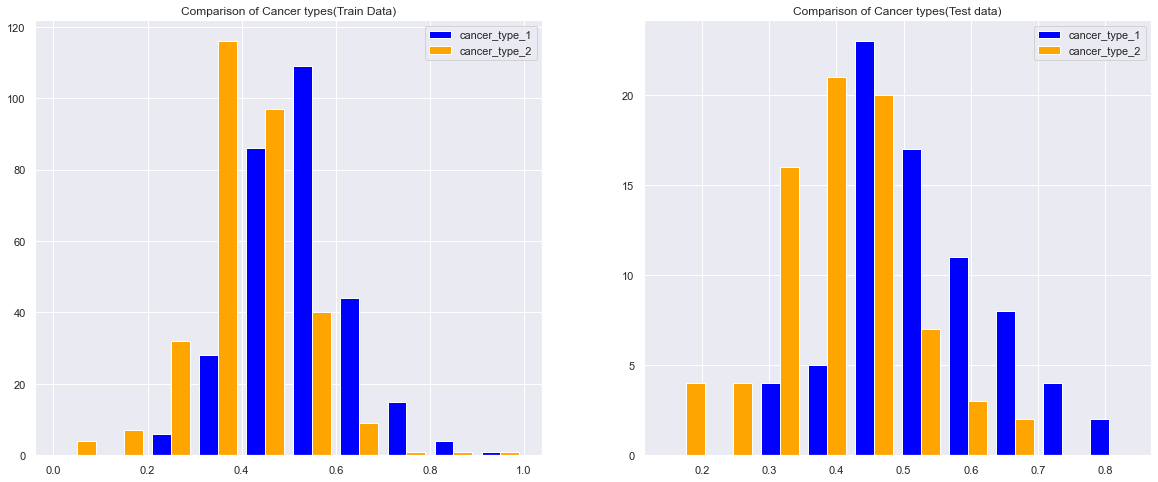

In [107]:


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
ax = ax.ravel()
X_train["Cancer_type"] = y_train
X_test["Cancer_type"] = y_test

ax[0].hist([X_train[X_train["Cancer_type"]== 1][best_pred], 
            X_train[X_train["Cancer_type"]== 0][best_pred]],  
            color = ["Blue", "orange"], 
            label = ["cancer_type_1", "cancer_type_2"])

ax[1].hist([X_test[X_test["Cancer_type"]== 1][best_pred],
            X_test[X_test["Cancer_type"]== 0][best_pred]],
            color = ["blue", "orange"],
            label = ["cancer_type_1", "cancer_type_2"])


ax[0].set_title("Comparison of Cancer types(Train Data)")
ax[0].legend()
ax[1].legend()
ax[1].set_title("Comparison of Cancer types(Test data)")


X_train = X_train.drop(["Cancer_type"], axis = 1)
X_test = X_test.drop(["Cancer_type"], axis = 1)

**1.4** Using your most useful gene from the previous part, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set (write code to implement and evaluate your hand-created model).

In [109]:
# Your code here

bayes_train = []
bayes_test = []
for val in X_train[best_pred]:
    if(val>0.45):
        bayes_train.append(1)
    else:
        bayes_train.append(0)
        
for val in X_test[best_pred]:
    if(val>0.45):
        bayes_test.append(1)
    else:
        bayes_test.append(0)

print("Training set: ", accuracy_score(y_train, bayes_train))
print("Testing set: ", accuracy_score(y_test, bayes_test))

Training set:  0.7071547420965059
Testing set:  0.7218543046357616


*Your answer here*

In both training and testing data, the graphs above reveal a 0.4-0.5 difference between cancer type 1 and cancer type 2. As a result, a 4.5 average was chosen.

<hr>

<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>

In class, we discussed how to use both linear regression and logistic regression for classification. For this question, you will explore these two models by working with the single gene that you identified above as being the best predictor.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor "best_predictor" to predict cancer type (use the normalized values of the gene). We could interpret the scores predicted by the regression model for a patient as being an estimate of the probability that the patient has Cancer_type=1 (AML). Is this a reasonable interpretation? If not, what is the problem with such?

Create a figure with the following items displayed on the same plot (Use training data):
 - the model's predicted value (the quantitative response from your linear regression model as a function of the normalized value of the best gene predictor)
 - the true binary response. 

In [71]:
# Your code here
import statsmodels.api as sm
from statsmodels.api import OLS
X_train_wcons = sm.add_constant(X_train[best_pred])
X_test_wcons = sm.add_constant(X_test[best_pred])

# fit
ols = OLS(endog=y_train, exog=X_train_wcons).fit()

In [72]:
y_hat_ols_train = ols.predict(X_train_wcons)
y_hat_ols_test = ols.predict(X_test_wcons)



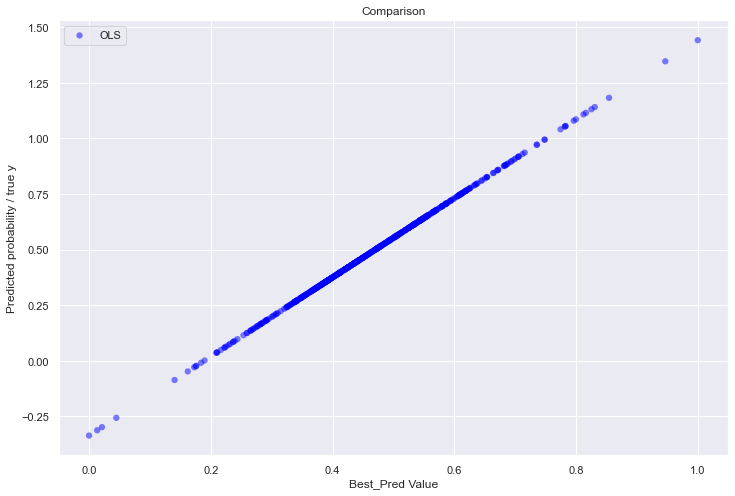

In [120]:
alpha = 0.5
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

fig.suptitle("")

ax.scatter(X_train[best_pred], 
           y_hat_ols_train, 
           label="OLS", 
           c='blue', 
           alpha=alpha, 
           edgecolor='none', s=40)



ax.legend(loc='best');
ax.set_xlabel('Best_Pred Value')
ax.set_ylabel('Predicted probability / true y')
ax.set_title('Comparison');

*Your answer here*



**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes classifier, which uses a threshold of 0.5. Evaluate the classification accuracy of this classification model on both the training and testing sets.

In [77]:
# Your code here
# predictions

# accuracy
print("OLS single predictor accuracy in train = %0.3f" 
      % accuracy_score(y_train, y_hat_ols_train>0.5))

print("OLS single predictor accuracy in test = %0.3f" 
      % accuracy_score(y_test, y_hat_ols_test>0.5))

OLS single predictor accuracy in train = 0.720
OLS single predictor accuracy in test = 0.695


**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 

In [26]:
# Your code here
logreg = LogisticRegression(C=100000, fit_intercept=False)
logreg.fit(X_train_wcons, y_train);

In [27]:
y_hat_logreg_train = logreg.predict_proba(X_train_wcons)[:,1]
y_hat_logreg_test = logreg.predict_proba(X_test_wcons)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_logreg_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_logreg_test>0.5))

Training Accuracy: 0.604
Test Accuracy: 0.675


*Your answer here* 


**2.4** Create 2 plots (one with training and one with test data) with 4 items displayed on each plot.
- the quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 

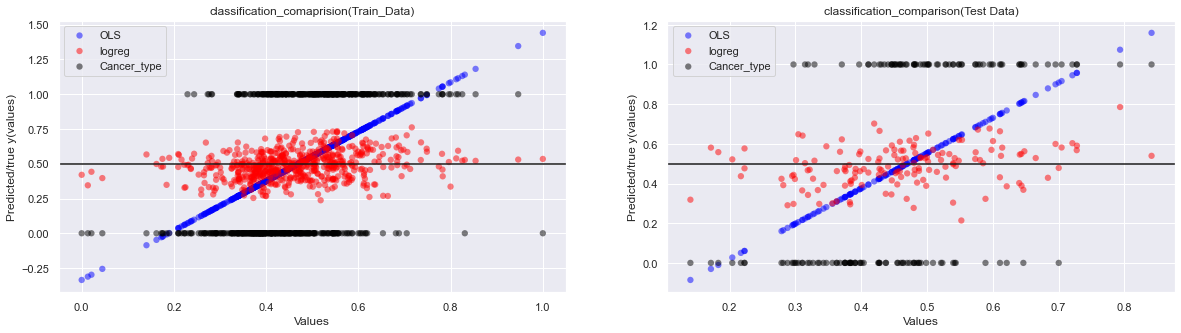

In [119]:
# Your code here
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

fig.suptitle("")

ax[0].scatter(X_train[best_pred], 
           y_hat_ols_train, 
           label="OLS", 
           c='blue', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax[0].scatter(X_train[best_pred], 
           y_hat_logreg_train, 
           label="logreg", 
           c='red', 
           alpha=alpha, 
           edgecolor='none', s=40)
ax[0].axhline(y = 0.5, color = 'k', linestyle = '-')
ax[0].scatter(X_train[best_pred], 
           y_train, 
           label="Cancer_type", 
           c='black', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax[0].legend(loc='best');
ax[0].set_xlabel('Values')
ax[0].set_ylabel('Predicted/true y(values)')
ax[0].set_title('classification_comaprision(Train_Data)');

ax[1].scatter(X_test[best_pred], 
           y_hat_ols_test, 
           label="OLS", 
           c='blue', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax[1].scatter(X_test[best_pred], 
           y_hat_logreg_test, 
           label="logreg", 
           c='red', 
           alpha=alpha, 
           edgecolor='none', s=40)
ax[1].axhline(y = 0.5, color = 'k', linestyle = '-')
ax[1].scatter(X_test[best_pred], 
           y_test, 
           label="Cancer_type", 
           c='black', 
           alpha=alpha, 
           edgecolor='none', s=40)

ax[1].legend(loc='best');
ax[1].set_xlabel('Values')
ax[1].set_ylabel('Predicted/true y(values)')
ax[1].set_title('classification_comparison(Test Data)');

*Your answer here*

In contrast, both logistic regression and linear regression produce projected values. For Training data, the values of Logistic regression are dense in numbers around the horizontal line at y=0.5. For testing data, the numbers are close to the horizontal line, but there is more space between the dots. For the two plots, there is no departure of the linear regression line using the logistic regression model (i.e., for training and testing data). The more appropriate model will be logistic regression.

<hr>

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>

**3.1** Next, fit a multiple logistic regression model with **all** the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [41]:
# Your code here
logregmul = LogisticRegression(C=100000, fit_intercept=False)

X_train_mul_wcons = sm.add_constant(X_train)
X_test_mul_wcons = sm.add_constant(X_test)

logregmul.fit(X_train_mul_wcons, y_train);

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [80]:
y_hat_logregmul_train = logregmul.predict_proba(X_train_mul_wcons)[:,1]
y_hat_logregmul_test = logregmul.predict_proba(X_test_mul_wcons)[:,1]

# accuracy
print("Training Accuracy: %0.3f" % accuracy_score(y_train, y_hat_logregmul_train>0.5))
print("Test Accuracy: %0.3f" % accuracy_score(y_test, y_hat_logregmul_test>0.5))

Training Accuracy: 1.000
Test Accuracy: 0.821


*Your answer here* 

The accuracy inclining considerably with all genes vs single gene in both training and test data.

**3.2** Comment on the classification accuracy of both the training and testing set. Given the results above, how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against possibly having a false sense of the overall efficacy/accuracy of the model as a whole?

*Your answer here*

Multiple logistic regression is good so far for calssification.  for generalizing capacity of a trained model, after modelling the data we want to generalize it to the data it has never seen before.



**3.3** Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization (i.e., L1 penalty) and 5-fold cross-validation to train the model on the training set. Report the classification accuracy on both the training and testing set.

In [84]:
# Your code here

#from sklearn.linear_model import LassoCV

alphas = (0.001, 0.01, 0.1, 10, 100, 1000, 10000)

# Let us do k-fold cross validation 
k = 5


fitted_lasso = LassoCV(alphas=alphas).fit(X_train, y_train)
pred_lasso = fitted_lasso.predict(X_test)
print("r^2 score for train lasso:", fitted_lasso.score(X_train, y_train))
print("r^2 score for test lasso:", fitted_lasso.score(X_test, y_test))

crossval=KFold(n_splits=5, random_state=1, shuffle=True)
model=LogisticRegression()

scores=cross_val_score(model,X_train,y_train,scoring="accuracy",cv=crossval,n_jobs=1)
scoresstr="Training Scores: "
for val in scores:
    scoresstr+=str(val)+", "
print(scoresstr)
scores=cross_val_score(model,X_test,y_test,scoring="accuracy",cv=crossval,n_jobs=1)
scoresstr="Testing Scores: "
for val in scores:
    scoresstr+=str(val)+ ", "
print(scoresstr)

r^2 score for train lasso: 0.525194950550042
r^2 score for test lasso: 0.45356004995168886


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Training Scores: 0.8264462809917356, 0.8583333333333333, 0.85, 0.8666666666666667, 0.8583333333333333, 


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing Scores: 0.6451612903225806, 0.8666666666666667, 0.9, 0.8, 0.8333333333333334, 


**3.4** Which model do you think generalizes the best? Explain your answer. 

*Your answer here*

In my view, multiple logistic regression with 5-fold is the best model. comparing with other model's accuracies, multiple Logistic regression model has better accuracies that others.